In [1]:
import re
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
icsd = pd.read_csv('ICSD/Zr-Ti.txt', sep='\t')
eddie_data = pd.read_excel('lattice.xlsx')

In [3]:
icsd = icsd.drop(['MeasuredDensity', 'Unnamed: 10'], axis=1)

In [4]:
icsd.head(3)

,CollectionCode,StructuredFormula,StructureType,Reference,StandardisedCellParameter,FormulaUnitsPerCell,Temperature,Pressure,SumFormula
0,31311,Zr0.33 Ti0.67 O2,PbO2(alpha)-Fe2N.94,"Zeitschrift fuer Kristallographie (1983) 164, ...",4.7060 5.5530 5.0240 90.000 90.000 90.000,4,293.0,0.101325,O2 Ti0.67 Zr0.33
1,69619,(Zr Ti) O4,PbO2(alpha)-Fe2N.94,Zeitschrift fuer Anorganische und Allgemeine C...,4.7855 5.4755 5.0277 90.000 90.000 90.000,2,293.0,0.101325,O4 Ti1 Zr1
2,153939,(Zr0.575 Ti0.425) O2,PbO2(alpha)-Fe2N.94,"Physics and Chemistry of Minerals (2005) 32, (...",4.8495 5.4635 5.0462 90.000 90.000 90.000,4,293.0,0.101325,O2 Ti0.425 Zr0.575


## Creating a new dataframe with the relevant data

In [5]:
def get_abc_from_cellparam(parameters):
    splitpar = [float(x) for x in parameters.split(' ')]
    return splitpar[0:3]

def get_angles_from_cellparam(parameters):
    splitpar = [float(x) for x in parameters.split(' ')]
    return splitpar[3:]

def set_abc(df):
    a, b, c = [], [], []
    for idx, row in df.iterrows():
        a_, b_, c_ = get_abc_from_cellparam(row.StandardisedCellParameter)
        a.append(a_)
        b.append(b_)
        c.append(c_)
    
    df['a'] = a
    df['b'] = b
    df['c'] = c
    
#     df = df.drop('StandardisedCellParameter', axis=1)
    return df

def set_angles(df):
    a, b, c = [], [], []
    for idx, row in df.iterrows():
        a_, b_, c_ = get_angles_from_cellparam(row.StandardisedCellParameter)
        a.append(a_)
        b.append(b_)
        c.append(c_)
    
    df['alpha'] = a
    df['beta'] = b
    df['gamma'] = c
    
#     df = df.drop('StandardisedCellParameter', axis=1)
    return df

In [6]:
df = icsd.copy()[
    ['CollectionCode',
     'StandardisedCellParameter',
     'FormulaUnitsPerCell',
     'Temperature',
     'Pressure',
     'SumFormula']
]

In [7]:
df = set_abc(df)
df = set_angles(df)
df = df.drop('StandardisedCellParameter', axis=1)

In [8]:
df = df[(np.abs(df[['alpha', 'beta', 'gamma']] - 90) < 1e-5).all(axis=1)]

## Changes in lattice parameters with respect to composition

In [9]:
df.head()

,CollectionCode,FormulaUnitsPerCell,Temperature,Pressure,SumFormula,a,b,c,alpha,beta,gamma
0,31311,4,293.0,0.101325,O2 Ti0.67 Zr0.33,4.7060,5.5530,5.0240,90.0,90.0,90.0
1,69619,2,293.0,0.101325,O4 Ti1 Zr1,4.7855,5.4755,5.0277,90.0,90.0,90.0
2,153939,4,293.0,0.101325,O2 Ti0.425 Zr0.575,4.8495,5.4635,5.0462,90.0,90.0,90.0
3,153940,4,293.0,0.101325,O2 Ti0.45 Zr0.55,4.8349,5.4801,5.0439,90.0,90.0,90.0
4,153941,4,293.0,0.101325,O2 Ti0.5 Zr0.5,4.8069,5.4785,5.0339,90.0,90.0,90.0


In [10]:
FLOAT_REGEX = '[-+]?[0-9]*\.?[0-9]*'
def get_composition(df, e1, e2):
    comp1, comp2 = [], []
    for idx, row in df.iterrows():
        comp1_ = float(re.findall('%s(%s)' % (e1, FLOAT_REGEX), row.SumFormula)[0])
        comp2_ = float(re.findall('%s(%s)' % (e2, FLOAT_REGEX), row.SumFormula)[0])
        
        comp1.append(100 * comp1_ / (comp1_ + comp2_))
        comp2.append(100 * comp2_ / (comp1_ + comp2_))
    
    df[e1] = comp1
    df[e2] = comp2
    return df

In [11]:
df = get_composition(df, 'Zr', 'Ti')

In [12]:
non_outliers = np.bitwise_and(
    df['CollectionCode'].values != 9389,
    df['CollectionCode'].values != 201961
)
df = df[non_outliers]

In [13]:
df

,CollectionCode,FormulaUnitsPerCell,Temperature,Pressure,SumFormula,a,b,c,alpha,beta,gamma,Zr,Ti
0,31311,4,293.0,0.101325,O2 Ti0.67 Zr0.33,4.7060,5.5530,5.0240,90.0,90.0,90.0,33.000000,67.000000
1,69619,2,293.0,0.101325,O4 Ti1 Zr1,4.7855,5.4755,5.0277,90.0,90.0,90.0,50.000000,50.000000
2,153939,4,293.0,0.101325,O2 Ti0.425 Zr0.575,4.8495,5.4635,5.0462,90.0,90.0,90.0,57.500000,42.500000
3,153940,4,293.0,0.101325,O2 Ti0.45 Zr0.55,4.8349,5.4801,5.0439,90.0,90.0,90.0,55.000000,45.000000
4,153941,4,293.0,0.101325,O2 Ti0.5 Zr0.5,4.8069,5.4785,5.0339,90.0,90.0,90.0,50.000000,50.000000
5,153942,4,293.0,0.101325,O2 Ti0.548 Zr0.452,4.7762,5.5010,5.0253,90.0,90.0,90.0,45.200000,54.800000
6,153943,4,293.0,0.101325,O2 Ti0.6 Zr0.4,4.7447,5.4925,5.0119,90.0,90.0,90.0,40.000000,60.000000
7,153944,4,293.0,0.101325,O2 Ti0.65 Zr0.35,4.7200,5.5078,5.0018,90.0,90.0,90.0,35.000000,65.000000
8,153945,4,293.0,0.101325,O2 Ti0.666 Zr0.333,4.7112,5.4944,4.9962,90.0,90.0,90.0,33.333333,66.666667
12,27311,2,293.0,0.101325,O4 Ti1 Zr1,4.8060,5.4470,5.0320,90.0,90.0,90.0,50.000000,50.000000


## Variation of the lattice parameters with respect to the temperature

In [14]:
rmse = lambda x, y: np.sqrt(np.mean((x - y)**2))

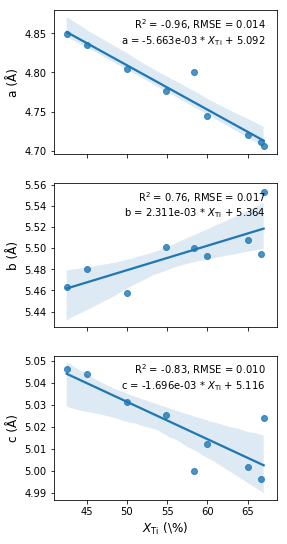

In [15]:
fig, ax_fig = plt.subplots(3, 1, figsize=(4, 9), sharex=True)

for y, ax in zip(['a', 'b', 'c'], ax_fig):
#     x_ = df.sort_values(by='Ti')['Ti'].values
#     y_ = df.sort_values(by='Ti')[y].values
    x_ = df.groupby('Ti').mean().reset_index()['Ti'].values
    y_ = df.groupby('Ti').mean().reset_index()[y].values
    
    regression = linregress(x_, y_)
    linear_fn = lambda x: regression.slope * x + regression.intercept
    
    error = rmse(y_, linear_fn(x_))
    
    lims = np.array([x_.min() * .95, x_.max() * 1.05])
    
#     ax.scatter(x_, y_)
#     ax.plot(lims, linear_fn(lims), 'k')
    
    sns.regplot(x_, y_, ax=ax)
    
    info = 'R$^2$ = %.2f, RMSE = %.3f\n%s = %.3e * $X_\\mathrm{Ti}$ + %.3f' \
        % (regression.rvalue, error, y, regression.slope, regression.intercept)
    
    ax.annotate(info, (0.95, 0.95), xycoords='axes fraction', va='top', ha='right')
    
    ax.set_ylabel('%s (Å)' % y, fontsize=12)

ax.set_xlabel('$X_\\mathrm{Ti}$ (\%)', fontsize=12)

plt.show()

## Using Eddie's data

In [16]:
elements = [
    'Ce', 'Ti', 'Hf', 'Sn', 'Ge',
    'Y', 'Sc', 'Yb', 'Er', 'Sm',
    'Nd', 'Gd', 'La', 'In', 'Nb',
    'Ta', 'Zr'
]

alloy = ['Zr', 'Ti']
other_elements = [el for el in elements if el not in alloy]

In [17]:
eddie = eddie_data.copy()

In [18]:
ZrTi_idx = np.bitwise_and.reduce([
#     np.abs(eddie.Ti + eddie.Zr - 100) < 1e-4,
    eddie.Ti != 0
])

eddie = eddie[ZrTi_idx]

In [19]:
eddie['other'] = eddie[other_elements].sum(axis=1)

In [20]:
room_temp = eddie['T(C)'] == 25

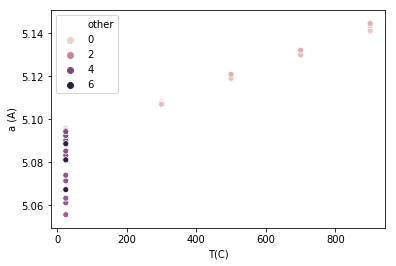

In [21]:
sns.scatterplot(data=eddie, x='T(C)', y='a (A)', hue='other')

In [22]:
bins = [-0.1, 0.2, 0.5, 0.7, 3.0, 5, 10]
eddie['other_bins'] = pd.cut(eddie['other'], bins)

In [23]:
eddie[room_temp]

,Ce,Ti,Hf,Sn,Ge,Y,Sc,Yb,Er,Sm,...,Radius ionic Shannon (A),Radius atomic Slater (A),Radius atomic Clementi (A),T(C),a (A),c (A),Ref,Notes,other,other_bins
0,0.0,19.685039,0.0,0.0,0.0,3.149606,0.0,0.0,0.0,0,...,0.825953,1.528346,2.002835,25.0,5.055700,5.204500,Hunter1998,high-res neutron data,3.149606,"(3.0, 5.0]"
1,0.0,15.735641,0.0,0.0,0.0,3.304485,0.0,0.0,0.0,0,...,0.830179,1.534658,2.014776,25.0,5.061200,5.201400,Hunter1998,high-res neutron data,3.304485,"(3.0, 5.0]"
2,0.0,14.749263,0.0,0.0,0.0,3.343166,0.0,0.0,0.0,0,...,0.831235,1.536234,2.017758,25.0,5.063349,5.199628,Kim1997,Webplotdigitizer,3.343166,"(3.0, 5.0]"
3,0.0,11.792453,0.0,0.0,0.0,3.459119,0.0,0.0,0.0,0,...,0.834399,1.540959,2.026698,25.0,5.071400,5.193900,Hunter1998,high-res neutron data,3.459119,"(3.0, 5.0]"
4,0.0,9.823183,0.0,0.0,0.0,3.536346,0.0,0.0,0.0,0,...,0.836507,1.544106,2.032652,25.0,5.074015,5.189055,Kim1997,Webplotdigitizer,3.536346,"(3.0, 5.0]"
5,0.0,9.708738,0.0,0.0,0.0,5.825243,0.0,0.0,0.0,0,...,0.840718,1.550000,2.034369,25.0,5.067333,5.182000,Capel1999,Webplotdigitizer,5.825243,"(5.0, 10.0]"
6,0.0,7.855460,0.0,0.0,0.0,3.613511,0.0,0.0,0.0,0,...,0.838613,1.547251,2.038602,25.0,5.081000,5.187900,Hunter1998,high-res neutron data,3.613511,"(3.0, 5.0]"
7,0.0,4.906771,0.0,0.0,0.0,3.729146,0.0,0.0,0.0,0,...,0.841768,1.551963,2.047517,25.0,5.083287,5.184217,Kim1997,Webplotdigitizer,3.729146,"(3.0, 5.0]"
8,0.0,4.906771,0.0,0.0,0.0,3.729146,0.0,0.0,0.0,0,...,0.841768,1.551963,2.047517,25.0,5.085229,5.185188,Jang2004,Webplotdigitizer,3.729146,"(3.0, 5.0]"
9,0.0,4.854369,0.0,0.0,0.0,5.825243,0.0,0.0,0.0,0,...,0.845573,1.557282,2.048932,25.0,5.081167,5.175167,Capel1999,Webplotdigitizer,5.825243,"(5.0, 10.0]"


In [24]:
more_bins = eddie[room_temp].groupby('other_bins').count().mean(axis=1) > 1
more_data_idx = [more_bins[b] for b in eddie[room_temp]['other_bins']]
plotting_data = eddie[room_temp][more_data_idx]

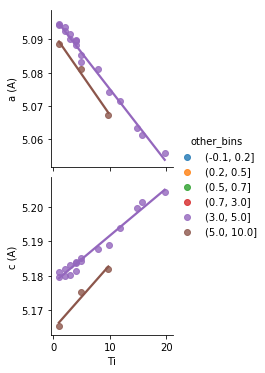

In [25]:
sns.pairplot(data=plotting_data, x_vars=['Ti'], y_vars=['a (A)', 'c (A)'],
             hue='other_bins', kind='reg', plot_kws={'ci': 0, 'order': 1}
            )

## Deviation from the Vegard's law

In [26]:
params_TiO2_RT = [4.594820, 2.958585 * 2]

In [54]:
plotting_data.groupby('Ti').mean().reset_index()

,Ti,Ce,Hf,Sn,Ge,Y,Sc,Yb,Er,Sm,...,Electron affinity (eV),Formal charge,Pettifor chemical scale,Radius ionic Shannon (A),Radius atomic Slater (A),Radius atomic Clementi (A),T(C),a (A),c (A),other
0,0.970874,0.0,0.0,0.0,0.0,5.825243,0.0,0.0,0.0,0,...,0.415699,3.941748,0.754466,0.849456,1.563107,2.060583,25.0,5.088667,5.165500,5.825243
1,0.980584,0.0,0.0,0.0,0.0,3.883114,0.0,0.0,0.0,0,...,0.417976,3.961169,0.756411,0.845970,1.558237,2.059388,25.0,5.094476,5.180338,3.883114
2,1.961554,0.0,0.0,0.0,0.0,3.844645,0.0,0.0,0.0,0,...,0.414618,3.961554,0.756744,0.844920,1.556669,2.056422,25.0,5.093116,5.181003,3.844645
3,2.942908,0.0,0.0,0.0,0.0,3.806160,0.0,0.0,0.0,0,...,0.411259,3.961938,0.757077,0.843870,1.555101,2.053455,25.0,5.090952,5.181668,3.806160
4,3.924647,0.0,0.0,0.0,0.0,3.767661,0.0,0.0,0.0,0,...,0.407898,3.962323,0.757410,0.842819,1.553532,2.050487,25.0,5.089219,5.182992,3.767661
5,4.854369,0.0,0.0,0.0,0.0,5.825243,0.0,0.0,0.0,0,...,0.402223,3.941748,0.755631,0.845573,1.557282,2.048932,25.0,5.081167,5.175167,5.825243
6,4.906771,0.0,0.0,0.0,0.0,3.729146,0.0,0.0,0.0,0,...,0.404536,3.962709,0.757743,0.841768,1.551963,2.047517,25.0,5.084258,5.184702,3.729146
7,7.855460,0.0,0.0,0.0,0.0,3.613511,0.0,0.0,0.0,0,...,0.394441,3.963865,0.758743,0.838613,1.547251,2.038602,25.0,5.081000,5.187900,3.613511
8,9.708738,0.0,0.0,0.0,0.0,5.825243,0.0,0.0,0.0,0,...,0.385379,3.941748,0.757087,0.840718,1.550000,2.034369,25.0,5.067333,5.182000,5.825243
9,9.823183,0.0,0.0,0.0,0.0,3.536346,0.0,0.0,0.0,0,...,0.387705,3.964637,0.759411,0.836507,1.544106,2.032652,25.0,5.074015,5.189055,3.536346


Text(0, 0.5, 'b (Å)')

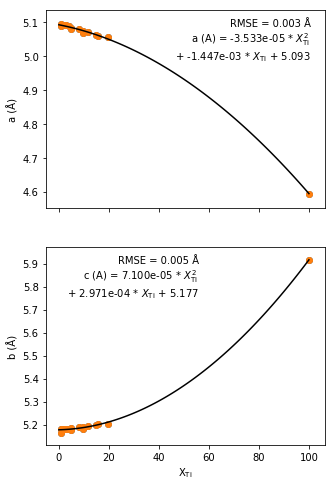

In [64]:
fig, ax_fig = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

data = plotting_data.groupby('Ti').mean().reset_index()

for i, (y, p) in enumerate(zip(['a (A)', 'c (A)'], [0.95, 0.55])):
    ax = ax_fig[i]
    x_ = data['Ti'].values
    x_ = np.append(x_, 100)
    y_ = data[y].values
    y_ = np.append(y_, params_TiO2_RT[i])

    ax.scatter(x_, y_)

    regression = linregress(x_, y_)
    linear_fn = lambda x: regression.slope * x + regression.intercept

    polyregression = np.polyfit(x_, y_, 2)
    quadratic_fn = lambda x: sum([
        coef * np.power(x, len(polyregression) - idx - 1)
        for idx, coef in enumerate(polyregression)
    ])

    error = rmse(y_, quadratic_fn(x_))

    lims = np.array([x_.min() * .95, x_.max() * 1.05])

    ax.scatter(x_, y_)
    xx = np.linspace(0, 100, 100)
    yy = quadratic_fn(xx)
    ax.plot(xx, yy, 'k')

    info = 'RMSE = %.3f Å\n%s = %.3e * $X_\\mathrm{Ti}^2$ \n+ %.3e * $X_\\mathrm{Ti}$ + %.3f' \
        % (error, y, polyregression[0], polyregression[1], polyregression[2])

    ax.annotate(info, (p, 0.95), xycoords='axes fraction', va='top', ha='right')

ax_fig[1].set_xlabel('X$_\mathrm{Ti}$')
ax_fig[0].set_ylabel('a (Å)')
ax_fig[1].set_ylabel('b (Å)')